<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Setup

In [37]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 906 (delta 151), reused 101 (delta 101), pack-reused 719 (from 1)
Receiving objects: 100% (906/906), 100.08 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (491/491), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [38]:
# Installs
!pip install pytorch-lightning
!pip install pytorch-forecasting

In [255]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Data Preparation

In [256]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])


In [257]:
# Cleaning
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)


# Model Setup

In [258]:
# Companies
print(df['Ticker'].unique())
# Targets
print(target_cols)

['ORCL' 'MSFT' 'AAPL' 'AVGO' 'TSLA' 'GOOGL' 'META' 'AMZN' 'AMD' 'NVDA']
['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']


In [259]:
# These were the best parameters that led to the best performance
target_to_encoder = {
    "Target_1day": 5,
    "Target_1week": 14,
    "Target_1month": 20,
    "Target_1year": 45
}

In [260]:
# Set parameters
ticker = "MSFT"                                   # Companies, can change
target = "Target_1week"                           # Targets, can change
max_encoder_length = target_to_encoder[target]    # Lookback period
max_prediction_length = 1
batch_size = 32
max_epochs = 50

In [261]:
# Remove other targets, they should not be features
# TODO: Make sure to run from data preparation chunk if you changed target
not_target = [col for col in df.columns if col != target and "Target" in col]
df.drop(not_target, axis = 1, inplace = True)


In [262]:
# Set all random seeds
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [263]:
# Filter data for the specific ticker
df_ticker = df[df['Ticker'] == ticker].copy()
df_ticker = df_ticker.sort_values(by='Date')
df_ticker[target] = df_ticker[target].fillna(0)
df_ticker[target] = df_ticker[target].replace([np.inf, -np.inf], 0)

# Create time index
df_ticker = df_ticker.reset_index(drop=True)
df_ticker['time_idx'] = df_ticker.index

# Get feature columns
feature_cols = [col for col in df_ticker.columns if 'Target' not in col
                and col not in ['Date', 'Ticker', 'time_idx']
                and not col.startswith('emb_')]

# Fill missing values
df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

# Classify features as known future vs unknown
known_future_features = []  # Add any features you know in advance here
unknown_features = [col for col in feature_cols if col not in known_future_features] # gurantees other targets not part of training data

print(f"Known future features: {known_future_features}")
print(f"Unknown features: {len(unknown_features)} features")

# Check if there's enough data
if len(df_ticker) <= max_encoder_length + max_prediction_length + 1:
    print(f"[{ticker}] {target}: Not enough data. Skipping.")
else:
    print(f"Data for {ticker} ready with {len(df_ticker)} rows and {len(feature_cols)} features.")

Known future features: []
Unknown features: 43 features
Data for MSFT ready with 652 rows and 43 features.


# Model Architecture

In [264]:
# Normalizer parameters
target_normalizer=GroupNormalizer(
    method="robust",              # Robust to outliers
    center=True,
    transformation= "softplus",   # Handle negative values
)
# Check for outliers
print(f"Target min: {df_ticker[target].min()}, max: {df_ticker[target].max()}")

Target min: -28.96075439453125, max: 30.35711669921875


In [265]:
# Create trainer with early stopping
early_stop = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=True,
    mode="min"
)

In [266]:
# Calculate cutoff points for train/val/test splits
total_len = len(df_ticker)

# Buffer between testing, training, and validation
gap_days = 5

test_start = int(total_len * 0.85) + gap_days # Last 15%
val_start = int(total_len * 0.70) + gap_days  # Next 15%
train_end = val_start              # First 70%

print(f"Data split indices:")
print(f"Training: 0 to {train_end-1} ({train_end} samples)")
print(f"Validation: {val_start} to {test_start-1} ({test_start - val_start} samples)")
print(f"Test: {test_start} to {total_len-1} ({total_len - test_start} samples)")

Data split indices:
Training: 0 to 460 (461 samples)
Validation: 461 to 558 (98 samples)
Test: 559 to 651 (93 samples)


In [267]:
# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    df_ticker[df_ticker.time_idx <= train_end],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=known_future_features,    # CHANGED: Only truly known future features
    time_varying_unknown_reals=[target] + unknown_features,  # CHANGED: Target plus unknown features
    target_normalizer=GroupNormalizer(groups=["Ticker"]),
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker[(df_ticker.time_idx >= val_start) & (df_ticker.time_idx <= test_start)],
    predict=False,
    min_prediction_idx=val_start + max_encoder_length
)

# Test dataset
test = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker[df_ticker.time_idx > test_start],
    predict=False,
    min_prediction_idx=test_start + max_encoder_length + 1
)

In [268]:
# Dataloaders
train_dataloader = training.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

val_dataloader = validation.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

test_dataloader = test.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")
print(f"Test samples: {len(test)}")

Training samples: 448
Validation samples: 85
Test samples: 78


In [269]:
# Initialize  TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    # change based on how much training and time
    learning_rate=0.001,
    hidden_size=64,
    attention_head_size=2,
    dropout=0.3,
    hidden_continuous_size=32,
    lstm_layers=2,
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
    optimizer="adamw",
    weight_decay=1e-2,
    reduce_on_plateau_reduction=2.0,
)

In [270]:
trainer = pl.Trainer(
    max_epochs=max_epochs,     # Increase epochs but let early stopping decide
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[early_stop],
    gradient_clip_val=0.1,     # Prevent exploding gradients
    accelerator="gpu",
    devices="auto",
)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [271]:
# Verification code with corrected variable names
print("\n=== Split Verification ===")
# Training set verification
print(f"Training data: {len(training)} samples (time indices 0-{train_end})")
print(f"Actual training time_idx range: {df_ticker[df_ticker.time_idx <= train_end].time_idx.min()}-{df_ticker[df_ticker.time_idx <= train_end].time_idx.max()}")

# Validation set verification
val_data = df_ticker[(df_ticker.time_idx > train_end) & (df_ticker.time_idx <= test_start)]
print(f"\nValidation data: {len(validation)} samples (time indices {train_end+1}-{test_start})")
print(f"Actual validation time_idx range: {val_data.time_idx.min()}-{val_data.time_idx.max()}")

# Test set verification
test_data = df_ticker[df_ticker.time_idx > test_start]
print(f"\nTest data: {len(test)} samples (time indices {test_start+1}-{total_len-1})")
print(f"Actual test time_idx range: {test_data.time_idx.min()}-{test_data.time_idx.max()}")

# Overlap checks using time indices
print("\n=== Overlap Analysis ===")
train_indices = set(df_ticker[df_ticker.time_idx <= train_end].time_idx)
val_indices = set(val_data.time_idx)
test_indices = set(test_data.time_idx)

print(f"Training-Val overlap: {len(train_indices & val_indices)} time indices")
print(f"Val-Test overlap: {len(val_indices & test_indices)} time indices")
print(f"Training-Test overlap: {len(train_indices & test_indices)} time indices")

# Sequence availability check
print("\n=== Viable Sequences ===")
def calculate_viable(data, split_name):
    viable = len([i for i in data.time_idx if i >= max_encoder_length])
    print(f"{split_name}: {viable} time indices can produce full sequences")

calculate_viable(df_ticker[df_ticker.time_idx <= train_end], "Training")
calculate_viable(val_data, "Validation")
calculate_viable(test_data, "Test")



=== Split Verification ===
Training data: 448 samples (time indices 0-461)
Actual training time_idx range: 0-461

Validation data: 85 samples (time indices 462-559)
Actual validation time_idx range: 462-559

Test data: 78 samples (time indices 560-651)
Actual test time_idx range: 560-651

=== Overlap Analysis ===
Training-Val overlap: 0 time indices
Val-Test overlap: 0 time indices
Training-Test overlap: 0 time indices

=== Viable Sequences ===
Training: 448 time indices can produce full sequences
Validation: 98 time indices can produce full sequences
Test: 92 time indices can produce full sequences


# Model Running

In [272]:
print(f"Starting training for {max_epochs} epochs...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
print("Training complete")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training for 50 epochs...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 2.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 192    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 376 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 4.079
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 4.079


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 4.053
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 4.053


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 4.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.01. New best score: 4.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.085 >= min_delta = 0.01. New best score: 3.947
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.085 >= min_delta = 0.01. New best score: 3.947


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: 3.895
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.053 >= min_delta = 0.01. New best score: 3.895


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.287 >= min_delta = 0.01. New best score: 3.608
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.287 >= min_delta = 0.01. New best score: 3.608


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.832 >= min_delta = 0.01. New best score: 2.776
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.832 >= min_delta = 0.01. New best score: 2.776


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 2.764
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 2.764


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.156 >= min_delta = 0.01. New best score: 2.608
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.156 >= min_delta = 0.01. New best score: 2.608


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.042 >= min_delta = 0.01. New best score: 2.566
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.01. New best score: 2.566


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 2.566. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 2.566. Signaling Trainer to stop.


Training complete


# Results

In [273]:
# Evaluate on validation set
val_predictions = tft.predict(val_dataloader)
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_pred = val_predictions.cpu().detach().numpy()
val_true = val_actuals.cpu().detach().numpy()

# Evaluate on test set
test_predictions = tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
test_pred = test_predictions.cpu().detach().numpy()
test_true = test_actuals.cpu().detach().numpy()

# Make sure arrays have the same length
val_min_length = min(len(val_true), len(val_pred))
test_min_length = min(len(test_true), len(test_pred))

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic u

In [274]:
# Calculate metrics
print(f"\n[{ticker}] Target: {target}")
print("Validation Metrics:")
val_mae = mean_absolute_error(val_true[:val_min_length], val_pred[:val_min_length])
val_rmse = np.sqrt(mean_squared_error(val_true[:val_min_length], val_pred[:val_min_length]))
val_r2 = r2_score(val_true[:val_min_length], val_pred[:val_min_length])
print(f"MAE : {val_mae:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R2  : {val_r2:.4f}")

print("\nTest Metrics:")
test_mae = mean_absolute_error(test_true[:test_min_length], test_pred[:test_min_length])
test_rmse = np.sqrt(mean_squared_error(test_true[:test_min_length], test_pred[:test_min_length]))
test_r2 = r2_score(test_true[:test_min_length], test_pred[:test_min_length])
print(f"MAE : {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R2  : {test_r2:.4f}")


[MSFT] Target: Target_1week
Validation Metrics:
MAE : 4.8964
RMSE: 6.0358
R2  : 0.5818

Test Metrics:
MAE : 5.8305
RMSE: 7.3267
R2  : 0.2297


# Visualization

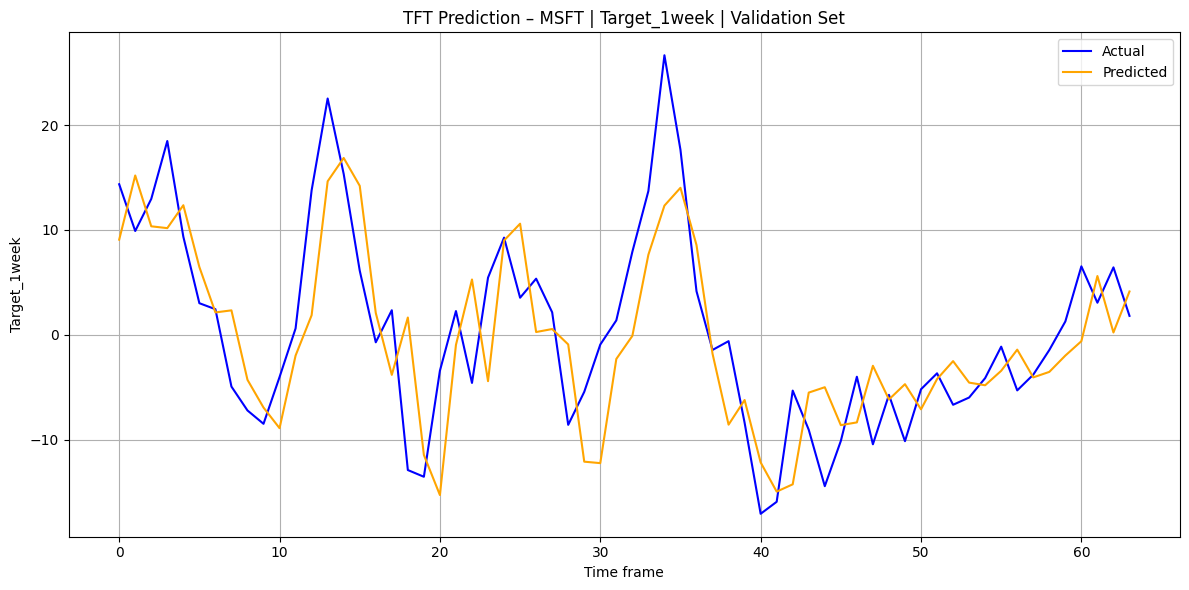

In [275]:
# Validation set visualization
plt.figure(figsize=(12, 6))
plt.plot(val_true[:val_min_length], label='Actual', color='blue')
plt.plot(val_pred[:val_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Validation Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

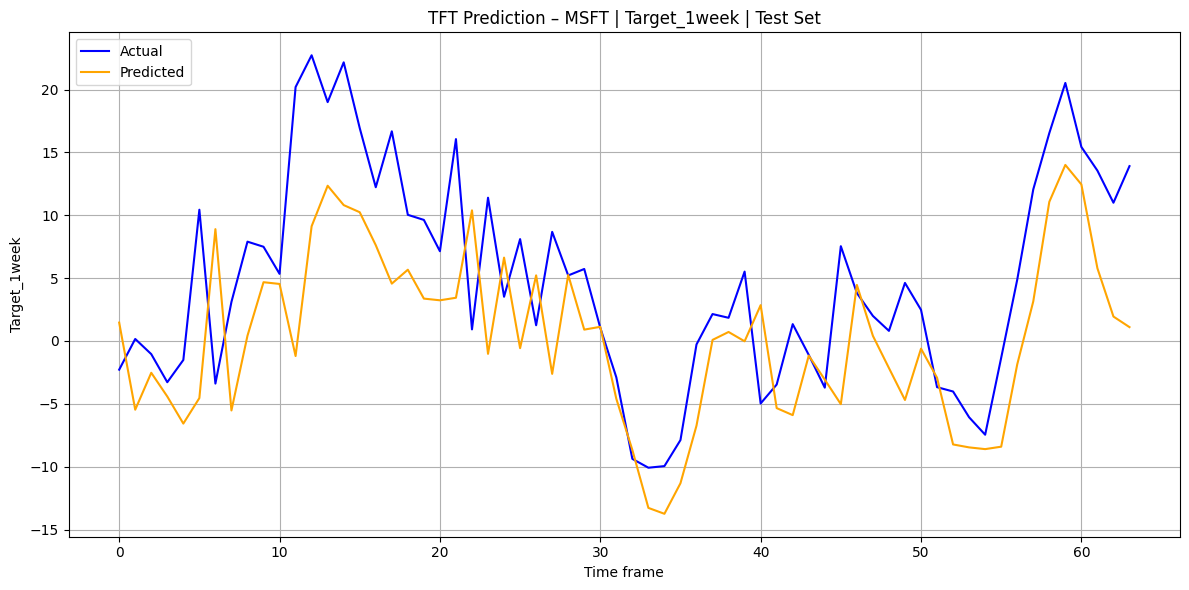

In [276]:
# Test set visualization
plt.figure(figsize=(12, 6))
plt.plot(test_true[:test_min_length], label='Actual', color='blue')
plt.plot(test_pred[:test_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Test Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [277]:
# Save the plot
filename = f'msft_tft_{target}.png'
plt.savefig(filename)
plt.show()

<Figure size 640x480 with 0 Axes>

In [278]:
import pandas as pd
import numpy as np
from datetime import datetime
import csv
from pathlib import Path

class ModelResultsTracker:
    def __init__(self, results_dir='model_results'):
        self.results_dir = Path(results_dir)
        self.results_dir.mkdir(exist_ok=True)
        self.results = []

    def add_result(self, ticker, target, encoder_length, model_type,
                   val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2):
        """Add a model run result"""
        result = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'ticker': ticker,
            'target': target,
            'encoder_length': encoder_length,
            'model_type': model_type,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        }
        self.results.append(result)

        # Auto-save after each addition
        self.save_results()

    def save_results(self):
        """Save results to CSV and TXT files"""
        # Save to CSV (append mode)
        df = pd.DataFrame(self.results)
        timestamp = datetime.now().strftime("%Y%m%d")
        csv_path = self.results_dir / f'model_results_{timestamp}.csv'

        # Check if file exists and append if it does
        if csv_path.exists():
            # Read existing data
            existing_df = pd.read_csv(csv_path)
            # Combine with new data
            combined_df = pd.concat([existing_df, df.iloc[-1:]], ignore_index=True)
            combined_df.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        # Save to formatted TXT (append mode)
        txt_path = self.results_dir / f'model_results_{timestamp}.txt'

        # Open in append mode
        mode = 'a' if txt_path.exists() else 'w'
        with open(txt_path, mode) as f:
            if mode == 'w':
                f.write("Model Performance Results\n")
                f.write("=" * 50 + "\n\n")

            # Only write the last result
            result = self.results[-1]
            f.write("Model Performance Results\n")
            f.write("=" * 50 + "\n\n")

            for result in self.results:
                f.write(f"Timestamp: {result['timestamp']}\n")
                f.write(f"Ticker: {result['ticker']} | Target: {result['target']}\n")
                f.write(f"Encoder Length: {result['encoder_length']} | Model: {result['model_type']}\n")
                f.write("-" * 50 + "\n")
                f.write("Validation Metrics:\n")
                f.write(f"  MAE: {result['val_mae']:.4f}\n")
                f.write(f"  RMSE: {result['val_rmse']:.4f}\n")
                f.write(f"  R²: {result['val_r2']:.4f}\n")
                f.write("Test Metrics:\n")
                f.write(f"  MAE: {result['test_mae']:.4f}\n")
                f.write(f"  RMSE: {result['test_rmse']:.4f}\n")
                f.write(f"  R²: {result['test_r2']:.4f}\n")
                f.write("=" * 50 + "\n\n")

        print(f"Results saved to {csv_path} and {txt_path}")

    def get_summary_table(self):
        """Get a summary table of all results"""
        df = pd.DataFrame(self.results)
        if len(df) > 0:
            # Create a pivot table for easy comparison
            pivot = df.pivot_table(
                values=['val_r2', 'test_r2'],
                index=['ticker', 'target'],
                columns=['encoder_length'],
                aggfunc='mean'
            )
            return pivot
        return None

    def plot_results(self, metric='r2'):
        """Create visualization of results"""
        import matplotlib.pyplot as plt

        df = pd.DataFrame(self.results)
        if len(df) == 0:
            print("No results to plot")
            return

        # Create a figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Validation R² by target and encoder length
        for target in df['target'].unique():
            target_data = df[df['target'] == target]
            ax1.plot(target_data['encoder_length'], target_data['val_r2'],
                    marker='o', label=target)

        ax1.set_xlabel('Encoder Length')
        ax1.set_ylabel('Validation R²')
        ax1.set_title('Validation R² by Target and Encoder Length')
        ax1.legend()
        ax1.grid(True)

        # Test R² by target and encoder length
        for target in df['target'].unique():
            target_data = df[df['target'] == target]
            ax2.plot(target_data['encoder_length'], target_data['test_r2'],
                    marker='o', label=target)

        ax2.set_xlabel('Encoder Length')
        ax2.set_ylabel('Test R²')
        ax2.set_title('Test R² by Target and Encoder Length')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig(self.results_dir / f'results_plot_{datetime.now().strftime("%Y%m%d")}.png')
        plt.show()

# Example usage
tracker = ModelResultsTracker()

# After each model run, add the results
tracker.add_result(
    ticker=ticker,
    target=target,
    encoder_length=max_encoder_length,
    model_type='TFT',
    val_mae=val_mae,
    val_rmse=val_rmse,
    val_r2=val_r2,
    test_mae=test_mae,
    test_rmse=test_rmse,
    test_r2=test_r2
)

Results saved to model_results/model_results_20250426.csv and model_results/model_results_20250426.txt
